In [1]:
import requests
import unicodedata
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, f1_score
from scipy.spatial.distance import cdist
from xgboost import XGBClassifier

from IPython.display import display



In [ ]:
url = 'http://svs.aids.gov.br/download/Vigitel/Vigitel-2019-peso-rake.xls'
r = requests.get(url, allow_redirects=True)
open('Vigitel-2019-peso-rake.xls', 'wb').write(r.content)

In [2]:
raw_data = pd.read_excel('Vigitel-2019-peso-rake.xls')
raw_data.head()

,chave,replica,ano,cidade,q6,q7,q8a,q8b,q8_anos,q9,...,papatres,hart,diab,ind_med_has,med_has,trat_med_has,ind_med_db,med_db,insulina,trat_med_db
0,311666031,29,2019,27,88,1,1,3.0,3,74,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,318136030,4,2019,27,65,1,8,NaN,0,57,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1321836026,6,2019,10,68,1,1,3.0,3,777,...,NaN,1,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,2323676021,16,2019,10,79,1,1,3.0,3,62,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2323716024,22,2019,10,70,1,1,3.0,3,66,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
columns_headers = pd.read_csv('/Users/rafaelalvesferreira/Docs_locais/Projetos/vigitel_predictions/data/external/headers.csv', sep=';')
columns_headers.drop(['Unnamed: 2'], axis=1, inplace=True)
columns_headers.head()


,tabela,nome
0,chave,chave
1,replica,replica
2,ano,ano
3,cidade,cidade
4,q6,idade_anos


In [5]:
columns_headers['nome'] = columns_headers['nome'].str.lower().str.lstrip()
columns_headers['nome'] = columns_headers['nome'].str.replace(' ', '_')

In [6]:
def remove_accents(a):
    return unicodedata.normalize('NFKD', a).encode('ascii', errors='ignore').decode('utf-8')

columns_headers['nome'] = columns_headers['nome'].apply(remove_accents)

In [7]:
lista_de_duplicados = columns_headers['nome'].duplicated(keep='last')
lista_de_duplicados = lista_de_duplicados[lista_de_duplicados == True]
lista_de_duplicados = list(lista_de_duplicados.index)
lista_de_duplicados

[19, 21, 86, 99, 100, 101, 102, 103, 111, 119, 130, 131, 132]

In [8]:
for i in lista_de_duplicados:
    columns_headers.nome.iloc[i] = f'{columns_headers.nome.iloc[i]}_{i}'
columns_headers.head(20)

,tabela,nome
0,chave,chave
1,replica,replica
2,ano,ano
3,cidade,cidade
4,q6,idade_anos
5,q7,sexo
6,q8a,escolaridade_grau
7,q8b,escolaridade_ano
8,q8_anos,anos_estudo
9,q9,peso_kg


In [9]:
columns_headers.loc[columns_headers['nome']=='fumantes']

,tabela,nome
159,fumante,fumantes


In [10]:
columns_headers.drop(range(0,4), inplace=True)
columns_headers.drop(range(6,159), inplace=True)

In [11]:
columns_headers

,tabela,nome
4,q6,idade_anos
5,q7,sexo
159,fumante,fumantes
160,mais20,consumode20oumaiscigarrosaodia
161,fumocasa,fumantespassivosnodomicilio
...,...,...
224,trat_med_has,hipertensos_em_tratamento_medicamentoso
225,ind_med_db,indicacao_medica_(db)
226,med_db,usodemedicamento(db)
227,insulina,usodeinsulina


In [12]:
raw_data

,chave,replica,ano,cidade,q6,q7,q8a,q8b,q8_anos,q9,...,papatres,hart,diab,ind_med_has,med_has,trat_med_has,ind_med_db,med_db,insulina,trat_med_db
0,311666031,29,2019,27,88,1,1,3.0,3,74,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,318136030,4,2019,27,65,1,8,NaN,0,57,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1321836026,6,2019,10,68,1,1,3.0,3,777,...,NaN,1,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,2323676021,16,2019,10,79,1,1,3.0,3,62,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2323716024,22,2019,10,70,1,1,3.0,3,66,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,94312585036,4,2019,17,70,2,6,5.0,16,57,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52439,98318694029,1,2019,7,87,2,6,4.0,15,38,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52440,18315885032,25,2019,17,86,2,6,4.0,15,777,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
52441,49311605030,3,2019,17,75,2,6,4.0,15,75,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [13]:
drop_cols = list(range(0,159))
drop_cols.pop(4)
drop_cols.pop(4)

5

In [14]:
raw_data.drop(raw_data.columns[drop_cols], axis=1, inplace=True)

In [15]:
raw_data

,q6,q7,fumante,mais20,fumocasa,fumotrab,eletronico,imc,imc_i,excpeso,...,papatres,hart,diab,ind_med_has,med_has,trat_med_has,ind_med_db,med_db,insulina,trat_med_db
0,88,1,0,0,0,1,0,26.218821,26.218821,1.0,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,65,1,1,0,0,0,0,22.546576,22.546576,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68,1,0,0,0,0,0,NaN,20.679012,NaN,...,NaN,1,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,79,1,0,0,1,0,0,21.453287,21.453287,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70,1,0,0,1,0,0,25.148605,25.148605,1.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,70,2,0,0,0,0,0,24.034407,24.034407,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52439,87,2,0,0,0,0,0,16.233072,16.233072,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52440,86,2,0,0,0,0,0,NaN,27.688778,NaN,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
52441,75,2,0,0,0,0,0,NaN,28.577961,NaN,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [16]:
headers_dict = dict(zip(columns_headers['tabela'], columns_headers['nome']))

In [17]:
headers_dict

{'q6': 'idade_anos',
 'q7': 'sexo',
 'fumante': 'fumantes',
 'mais20': 'consumode20oumaiscigarrosaodia',
 'fumocasa': 'fumantespassivosnodomicilio',
 'fumotrab': 'fumantespassivosnolocaldetrabalho',
 'eletronico': 'eletronico',
 'imc': 'imc',
 'imc_i': 'imccomimputacoes',
 'excpeso': 'excessodepeso',
 'excpeso_i': 'excessodepesocomimputacoes',
 'obesid': 'obesidade',
 'obesid_i': 'obesidadecomimputacoes',
 'hortareg': 'consumoregulardehortalicas(5xoumais/sem)',
 'frutareg': 'consumoregulardefrutas(5xoumais/sem)',
 'flvreg': 'consumoregulardefrutasehortalicas(5xoumais/sem)',
 'cruadia': 'contagemdehortalicascruas/dia',
 'cozidadia': 'contagemdehortalicascozidas/dia',
 'hortadia': 'contagemdehortalicas/dia',
 'sucodia': 'contagemsuco/dia-max.1/dia',
 'sofrutadia': 'contagemfruta/dia-semsuco',
 'frutadia': 'contagemfrutatotal/dia',
 'flvdia': 'contagemfrutaehortalicatotal/dia',
 'flvreco': 'consumorecomendadodefrutasehortalicas',
 'refritl5': 'consumoregularderefrigerantes(5xoumais/sem)',

In [18]:
df = raw_data.rename(columns=headers_dict)

In [19]:
df

,idade_anos,sexo,fumantes,consumode20oumaiscigarrosaodia,fumantespassivosnodomicilio,fumantespassivosnolocaldetrabalho,eletronico,imc,imccomimputacoes,excessodepeso,...,papanicolaunosultimostresanos,hipertensaoarterial,diabetes,indicacaomedica(has),usodemedicamento(has),hipertensos_em_tratamento_medicamentoso,indicacao_medica_(db),usodemedicamento(db),usodeinsulina,diabeticosemtratamentomedicamentoso
0,88,1,0,0,0,1,0,26.218821,26.218821,1.0,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,65,1,1,0,0,0,0,22.546576,22.546576,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68,1,0,0,0,0,0,NaN,20.679012,NaN,...,NaN,1,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,79,1,0,0,1,0,0,21.453287,21.453287,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70,1,0,0,1,0,0,25.148605,25.148605,1.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,70,2,0,0,0,0,0,24.034407,24.034407,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52439,87,2,0,0,0,0,0,16.233072,16.233072,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52440,86,2,0,0,0,0,0,NaN,27.688778,NaN,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
52441,75,2,0,0,0,0,0,NaN,28.577961,NaN,...,NaN,1,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [20]:
count = df.isna().sum()
na_df = list(zip(count.index, count))
na_df = pd.DataFrame(na_df, columns=['pergunta', 'quantidade'])
na_df = na_df[na_df.quantidade > 7800]

In [21]:
pd.options.display.max_rows = None
display(na_df)

,pergunta,quantidade
56,faixasdeidadealvoparamamografia,38612
57,mamografia,38612
58,mamografianosultimosdoisanos,38612
59,recodeofq6(idade(anos)),36716
60,faixasdeidadealvoparapapanicolau,32852
61,papanicolau,32852
62,papanicolaunosultimostresanos,32852
65,indicacaomedica(has),33167
66,usodemedicamento(has),33167
67,hipertensos_em_tratamento_medicamentoso,33167


In [22]:
drop_list = na_df.pergunta.to_list()
drop_list

['faixasdeidadealvoparamamografia',
 'mamografia',
 'mamografianosultimosdoisanos',
 'recodeofq6(idade(anos))',
 'faixasdeidadealvoparapapanicolau',
 'papanicolau',
 'papanicolaunosultimostresanos',
 'indicacaomedica(has)',
 'usodemedicamento(has)',
 'hipertensos_em_tratamento_medicamentoso',
 'indicacao_medica_(db)',
 'usodemedicamento(db)',
 'usodeinsulina',
 'diabeticosemtratamentomedicamentoso']

In [23]:
# Removendo as colunas:
df.drop(drop_list, axis=1, inplace=True)

<AxesSubplot:>

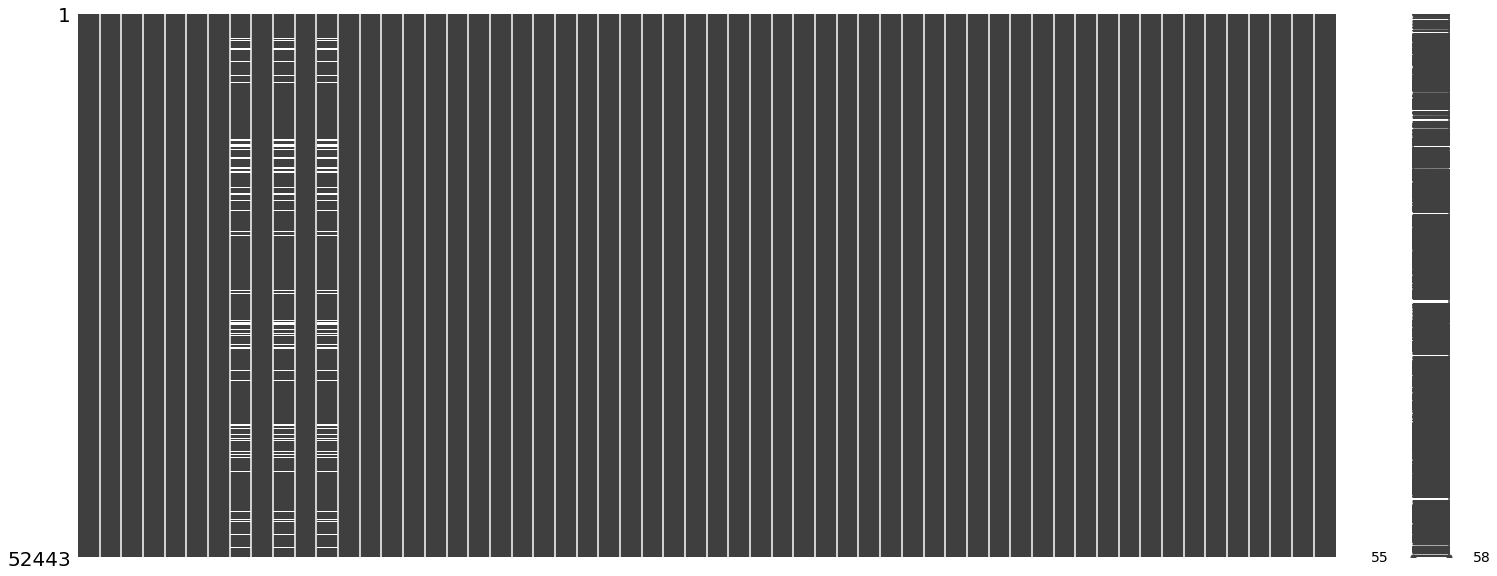

In [24]:
msno.matrix(df)

In [25]:
pd.options.display.max_rows = 20

In [26]:
pd.options.display.max_columns = None
df

,idade_anos,sexo,fumantes,consumode20oumaiscigarrosaodia,fumantespassivosnodomicilio,fumantespassivosnolocaldetrabalho,eletronico,imc,imccomimputacoes,excessodepeso,excessodepesocomimputacoes,obesidade,obesidadecomimputacoes,consumoregulardehortalicas(5xoumais/sem),consumoregulardefrutas(5xoumais/sem),consumoregulardefrutasehortalicas(5xoumais/sem),contagemdehortalicascruas/dia,contagemdehortalicascozidas/dia,contagemdehortalicas/dia,contagemsuco/dia-max.1/dia,contagemfruta/dia-semsuco,contagemfrutatotal/dia,contagemfrutaehortalicatotal/dia,consumorecomendadodefrutasehortalicas,consumoregularderefrigerantes(5xoumais/sem),consumoregulardefeijao(5xoumais/sem),score_sf,consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas,score_upp,consumodecincooumaisgruposdealimentosultraprocessados,tipo_atv._fis._no_tempo_livre_(lazer),frequenciaderealizacaodeatv.fis.notempolivre(lazer),tempo_de_realizacao_de_atv._fis._no_tempo_livre_(lazer),af*freq*time_(continua),atividadefisicasuficientenolazer-somentetempo/semfrequencia(apartirde2012),atividadefisicanodeslocamento,atividadefisicanotrabalhodomestico,atividadefisicanotrabalho,inatividadefisica,duracao_diaria_do_deslocamento_para_trabalho_(min),duracao_diaria_do_deslocamento_para_o_escola_(min),duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_da_atividade_fisica_laboral_(min),duracao_semanal_da_atividade_fisica_domestica(min),atividade_fisica_>=_150min/sem_em_3_dominios,atividadefisica<=150min/semem3dominios,habitodeassistirtv-3hrs/dia,tempodetela(naotv)-3hrs/dia,quantas_horas_assiste_tv_/_dia,tempo_computador_tablet_celular_tempolivre,tempodetela(total)-3hrs/dia,consumoabusivodealcool,conducaodeveiculoaposconsumoabusivodebebidaalcoolica,conducaodeveiculoaposconsumobebidaalcoolica,avaliacaoruimdacondicaodesaude,hipertensaoarterial,diabetes
0,88,1,0,0,0,1,0,26.218821,26.218821,1.0,1,0.0,0,0,1,0,1,1,2,1,3,4,6,0,0,1,2,0,1,0,0,0.0,0.0,0.00,0,0,0,1,0,0.0,0.0,0.0,0.0,3360,0,1,0,0,0,0.0,0.0,0,0,0,0,0,1,0
1,65,1,1,0,0,0,0,22.546576,22.546576,0.0,0,0.0,0,0,1,0,1,0,1,1,0,1,2,0,1,1,2,0,1,0,0,0.0,0.0,0.00,0,1,0,1,0,44.5,0.0,44.5,222.5,0,0,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0
2,68,1,0,0,0,0,0,NaN,20.679012,NaN,0,NaN,0,0,0,0,1,1,2,1,1,2,4,0,0,1,4,0,1,0,0,0.0,0.0,0.00,0,0,0,1,0,0.0,0.0,0.0,0.0,1800,0,1,0,0,0,2.5,0.0,0,0,0,1,0,1,1
3,79,1,0,0,1,0,0,21.453287,21.453287,0.0,0,0.0,0,1,1,1,2,2,4,0,2,2,6,1,0,1,5,1,4,0,1,3.5,34.5,120.75,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,2.5,0.0,0,0,0,0,0,0,0
4,70,1,0,0,1,0,0,25.148605,25.148605,1.0,1,0.0,0,0,0,0,1,1,2,1,2,3,5,0,0,1,5,1,3,0,1,3.5,34.5,120.75,0,1,1,1,0,44.5,0.0,44.5,222.5,0,50,1,0,0,0,1.5,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,70,2,0,0,0,0,0,24.034407,24.034407,0.0,0,0.0,0,1,1,1,2,2,4,0,2,2,6,1,0,0,5,1,2,0,1,1.5,54.5,81.75,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,2.5,0.0,0,0,0,0,0,0,0
52439,87,2,0,0,0,0,0,16.233072,16.233072,0.0,0,0.0,0,1,1,1,1,1,2,0,1,1,3,0,0,1,3,0,3,0,2,1.5,34.5,103.50,0,0,1,1,0,0.0,0.0,0.0,0.0,47397,960,1,0,0,0,1.0,0.0,0,0,0,0,0,0,0
52440,86,2,0,0,0,0,0,NaN,27.688778,NaN,1,NaN,0,0,0,0,0,0,0,0,2,2,2,0,0,0,1,0,0,0,1,3.5,34.5,120.75,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,3.5,0.0,1,0,0,0,0,1,0
52441,75,2,0,0,0,0,0,NaN,28.577961,NaN,1,NaN,0,1,0,0,1,1,2,0,2,2,4,0,1,0,7,1,5,1,1,1.5,60.0,90.00,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,3.5,0.0,1,0,0,0,0,1,0


In [27]:
df['sexo'][df['sexo']==2] = 0

In [28]:
df.describe()

,idade_anos,sexo,fumantes,consumode20oumaiscigarrosaodia,fumantespassivosnodomicilio,fumantespassivosnolocaldetrabalho,eletronico,imc,imccomimputacoes,excessodepeso,excessodepesocomimputacoes,obesidade,obesidadecomimputacoes,consumoregulardehortalicas(5xoumais/sem),consumoregulardefrutas(5xoumais/sem),consumoregulardefrutasehortalicas(5xoumais/sem),contagemdehortalicascruas/dia,contagemdehortalicascozidas/dia,contagemdehortalicas/dia,contagemsuco/dia-max.1/dia,contagemfruta/dia-semsuco,contagemfrutatotal/dia,contagemfrutaehortalicatotal/dia,consumorecomendadodefrutasehortalicas,consumoregularderefrigerantes(5xoumais/sem),consumoregulardefeijao(5xoumais/sem),score_sf,consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas,score_upp,consumodecincooumaisgruposdealimentosultraprocessados,tipo_atv._fis._no_tempo_livre_(lazer),frequenciaderealizacaodeatv.fis.notempolivre(lazer),tempo_de_realizacao_de_atv._fis._no_tempo_livre_(lazer),af*freq*time_(continua),atividadefisicasuficientenolazer-somentetempo/semfrequencia(apartirde2012),atividadefisicanodeslocamento,atividadefisicanotrabalhodomestico,atividadefisicanotrabalho,inatividadefisica,duracao_diaria_do_deslocamento_para_trabalho_(min),duracao_diaria_do_deslocamento_para_o_escola_(min),duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_da_atividade_fisica_laboral_(min),duracao_semanal_da_atividade_fisica_domestica(min),atividade_fisica_>=_150min/sem_em_3_dominios,atividadefisica<=150min/semem3dominios,habitodeassistirtv-3hrs/dia,tempodetela(naotv)-3hrs/dia,quantas_horas_assiste_tv_/_dia,tempo_computador_tablet_celular_tempolivre,tempodetela(total)-3hrs/dia,consumoabusivodealcool,conducaodeveiculoaposconsumoabusivodebebidaalcoolica,conducaodeveiculoaposconsumobebidaalcoolica,avaliacaoruimdacondicaodesaude,hipertensaoarterial,diabetes
count,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,47119.000000,52443.000000,47119.000000,52443.000000,47119.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,5.244300e+04,5.244300e+04,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000,52443.000000
mean,54.333314,0.349980,0.068512,0.016685,0.047423,0.040043,0.010488,26.498320,26.492276,0.577665,0.573346,0.202912,0.206624,0.523311,0.690979,0.409588,1.067025,1.120626,2.187651,0.776138,1.631543,2.407681,4.595332,0.260264,0.084854,0.534638,3.870526,0.371851,2.268310,0.115325,0.635356,1.980293,28.099584,117.317349,0.371394,0.093931,0.384074,0.292813,0.180177,3.937885,1.727743,5.665627,28.328137,2.449842e+04,1.119224e+05,0.479664,0.520336,0.248803,0.138188,2.243798,1.377419,0.561829,0.127929,0.005759,0.052514,0.051847,0.367561,0.119196
std,18.273770,0.476968,0.252626,0.128089,0.212544,0.196063,0.101871,4.970893,5.168887,0.493937,0.494596,0.402172,0.404887,0.499461,0.462094,0.491762,0.523674,0.551302,0.891916,0.416835,0.828459,0.954355,1.404568,0.438783,0.278667,0.498804,1.607961,0.483304,1.819962,0.319417,0.614954,2.260344,27.819390,146.755457,0.483182,0.291735,0.486380,0.455058,0.384338,12.464396,8.158086,15.422536,77.112680,9.423229e+05,1.914941e+06,0.499591,0.499591,0.432324,0.345101,1.520935,1.570622,0.496167,0.334014,0.075668,0.223064,0.221720,0.482146,0.324022
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.962564,9.962564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [29]:
categoricos = ['sexo', 
 'fumantes',
 'consumode20oumaiscigarrosaodia',
 'fumantespassivosnodomicilio',
 'fumantespassivosnolocaldetrabalho',
 'eletronico',
 'excessodepesocomimputacoes',
 'obesidadecomimputacoes',
 'consumoregulardehortalicas(5xoumais/sem)',
 'consumoregulardefrutas(5xoumais/sem)',
 'consumoregulardefrutasehortalicas(5xoumais/sem)',
 'consumorecomendadodefrutasehortalicas',
 'consumoregularderefrigerantes(5xoumais/sem)',
 'consumoregulardefeijao(5xoumais/sem)',
 'consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas',
 'consumodecincooumaisgruposdealimentosultraprocessados',
 'tipo_atv._fis._no_tempo_livre_(lazer)',
 'atividadefisicasuficientenolazer-somentetempo/semfrequencia(apartirde2012)',
 'atividadefisicanodeslocamento',
 'atividadefisicanotrabalhodomestico',
 'atividadefisicanotrabalho',
 'inatividadefisica',
 'atividade_fisica_>=_150min/sem_em_3_dominios',
 'atividadefisica<=150min/semem3dominios',
 'habitodeassistirtv-3hrs/dia',
 'tempodetela(naotv)-3hrs/dia',
 'tempodetela(total)-3hrs/dia',
 'consumoabusivodealcool',
 'conducaodeveiculoaposconsumoabusivodebebidaalcoolica',
 'conducaodeveiculoaposconsumobebidaalcoolica',
 'avaliacaoruimdacondicaodesaude',
 'hipertensaoarterial',
 'diabetes']

In [30]:
for column_name in categoricos:
    df[column_name] = df[column_name].astype('category')

In [31]:
df.drop(['score_sf', 'score_upp',  'af*freq*time_(continua)'], axis=1, inplace=True)

In [32]:
numericos = [
 'idade_anos',
 'imccomimputacoes',
 'contagemdehortalicascruas/dia',
 'contagemdehortalicascozidas/dia',
 'contagemdehortalicas/dia',
 'contagemsuco/dia-max.1/dia',
 'contagemfruta/dia-semsuco',
 'contagemfrutatotal/dia',
 'contagemfrutaehortalicatotal/dia',
 'tipo_atv._fis._no_tempo_livre_(lazer)',
 'frequenciaderealizacaodeatv.fis.notempolivre(lazer)',
 'tempo_de_realizacao_de_atv._fis._no_tempo_livre_(lazer)',
 'duracao_diaria_do_deslocamento_para_trabalho_(min)',
 'duracao_diaria_do_deslocamento_para_o_escola_(min)',
 'duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_(min)',
 'duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_(min)',
 'duracao_semanal_da_atividade_fisica_laboral_(min)',
 'duracao_semanal_da_atividade_fisica_domestica(min)',
 'quantas_horas_assiste_tv_/_dia',
 'tempo_computador_tablet_celular_tempolivre'
 ]

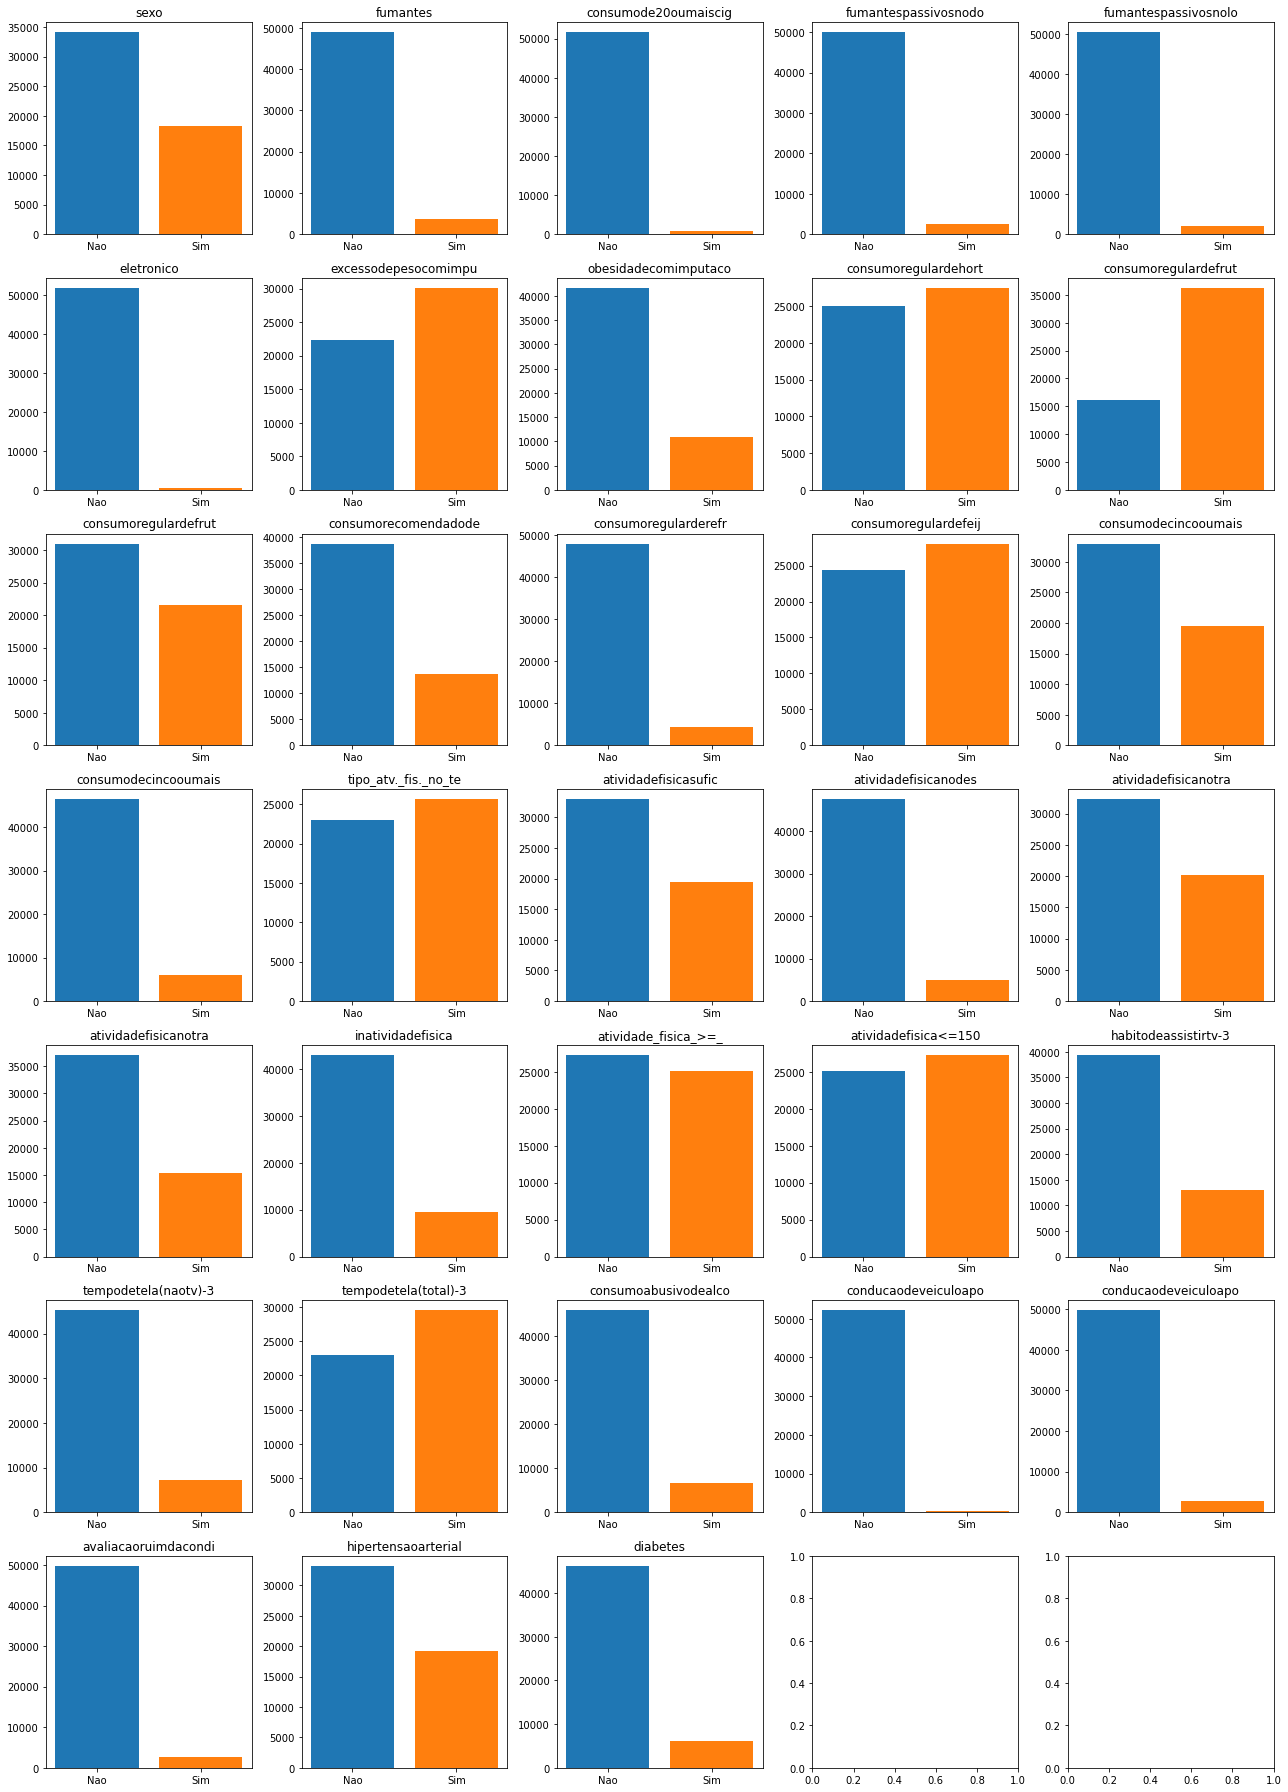

In [33]:
fig, axs = plt.subplots(7, 5, figsize=(18, 25))

for ax, feat in zip(axs.flatten(), categoricos):
        ax.bar('Nao',df[feat].loc[(df[feat]==0)].count())
        ax.bar('Sim',df[feat].loc[(df[feat]==1)].count())
        ax.set_title(f'{feat[:20]}')
plt.tight_layout()

In [34]:
count = df.isna().sum()
na_df = list(zip(count.index, count))
na_df = pd.DataFrame(na_df, columns=['pergunta', 'quantidade'])
na_df = na_df[na_df.quantidade > 0]

In [35]:
na_df

,pergunta,quantidade
7,imc,5324
9,excessodepeso,5324
11,obesidade,5324


In [36]:
drop_list = na_df.pergunta.to_list()
drop_list

['imc', 'excessodepeso', 'obesidade']

In [37]:
df.drop(drop_list, axis=1, inplace=True)

<AxesSubplot:>

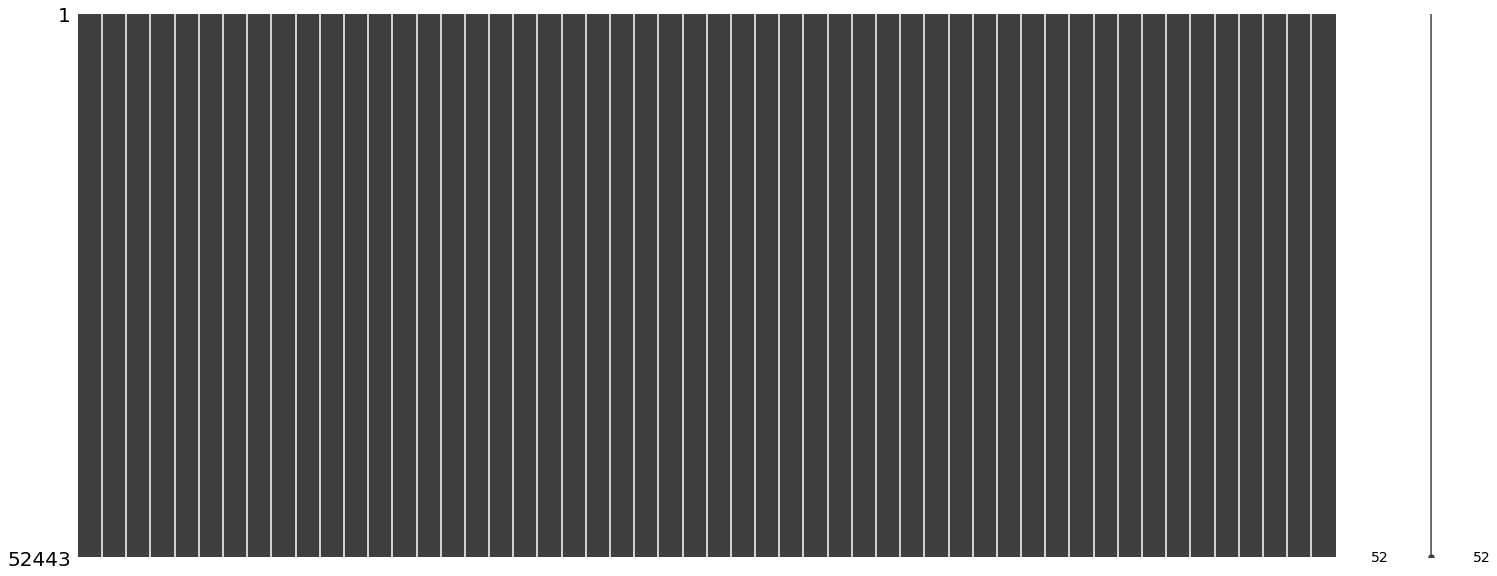

In [38]:
msno.matrix(df)

In [39]:
df_raw = df.copy(deep=True)

scaler = StandardScaler()
df[numericos] = scaler.fit_transform(df[numericos])

In [41]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {}
silhouette = []
K = range(2,16) 

for k in K: 
    #Instanciando o modelo e testando para um dado K
    kmeanModel = KMeans(n_clusters=k, random_state=10)
    kmeanModel.fit(df)
    kmeans_labels = kmeanModel.predict(df)
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'cityblock'),axis=1)) / df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'cityblock'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    silhouette.append(silhouette_score(df, kmeans_labels))  


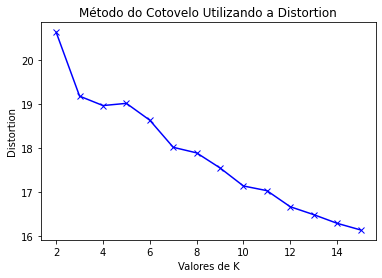

In [42]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Valores de K') 
plt.ylabel('Distortion') 
plt.title('Método do Cotovelo Utilizando a Distortion') 
plt.show()

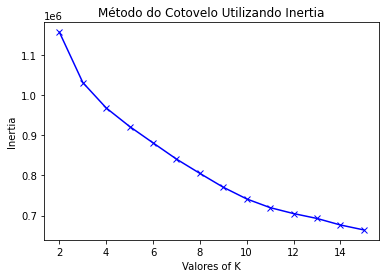

In [43]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Valores of K') 
plt.ylabel('Inertia') 
plt.title('Método do Cotovelo Utilizando Inertia') 
plt.show() 

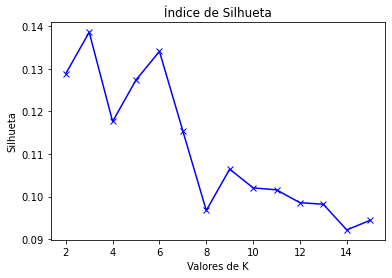

In [44]:
plt.plot(K, silhouette, 'bx-') 
plt.xlabel('Valores de K') 
plt.ylabel('Silhueta') 
plt.title('Índice de Silhueta') 
plt.show()

In [45]:
kmeanModel = KMeans(n_clusters=3)
kmeans_labels = kmeanModel.fit_predict(df)
silhouette_avg = silhouette_score(df, kmeans_labels)
silhouette_avg


0.13858802536902903

In [46]:
df_raw['kmeans_labels'] = kmeans_labels


In [47]:
df_raw

,idade_anos,sexo,fumantes,consumode20oumaiscigarrosaodia,fumantespassivosnodomicilio,fumantespassivosnolocaldetrabalho,eletronico,imccomimputacoes,excessodepesocomimputacoes,obesidadecomimputacoes,consumoregulardehortalicas(5xoumais/sem),consumoregulardefrutas(5xoumais/sem),consumoregulardefrutasehortalicas(5xoumais/sem),contagemdehortalicascruas/dia,contagemdehortalicascozidas/dia,contagemdehortalicas/dia,contagemsuco/dia-max.1/dia,contagemfruta/dia-semsuco,contagemfrutatotal/dia,contagemfrutaehortalicatotal/dia,consumorecomendadodefrutasehortalicas,consumoregularderefrigerantes(5xoumais/sem),consumoregulardefeijao(5xoumais/sem),consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas,consumodecincooumaisgruposdealimentosultraprocessados,tipo_atv._fis._no_tempo_livre_(lazer),frequenciaderealizacaodeatv.fis.notempolivre(lazer),tempo_de_realizacao_de_atv._fis._no_tempo_livre_(lazer),atividadefisicasuficientenolazer-somentetempo/semfrequencia(apartirde2012),atividadefisicanodeslocamento,atividadefisicanotrabalhodomestico,atividadefisicanotrabalho,inatividadefisica,duracao_diaria_do_deslocamento_para_trabalho_(min),duracao_diaria_do_deslocamento_para_o_escola_(min),duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_da_atividade_fisica_laboral_(min),duracao_semanal_da_atividade_fisica_domestica(min),atividade_fisica_>=_150min/sem_em_3_dominios,atividadefisica<=150min/semem3dominios,habitodeassistirtv-3hrs/dia,tempodetela(naotv)-3hrs/dia,quantas_horas_assiste_tv_/_dia,tempo_computador_tablet_celular_tempolivre,tempodetela(total)-3hrs/dia,consumoabusivodealcool,conducaodeveiculoaposconsumoabusivodebebidaalcoolica,conducaodeveiculoaposconsumobebidaalcoolica,avaliacaoruimdacondicaodesaude,hipertensaoarterial,diabetes,kmeans_labels
0,88,1,0,0,0,1,0,26.218821,1,0,0,1,0,1,1,2,1,3,4,6,0,0,1,0,0,0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,3360,0,1,0,0,0,0.0,0.0,0,0,0,0,0,1,0,0
1,65,1,1,0,0,0,0,22.546576,0,0,0,1,0,1,0,1,1,0,1,2,0,1,1,0,0,0,0.0,0.0,0,1,0,1,0,44.5,0.0,44.5,222.5,0,0,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0,2
2,68,1,0,0,0,0,0,20.679012,0,0,0,0,0,1,1,2,1,1,2,4,0,0,1,0,0,0,0.0,0.0,0,0,0,1,0,0.0,0.0,0.0,0.0,1800,0,1,0,0,0,2.5,0.0,0,0,0,1,0,1,1,0
3,79,1,0,0,1,0,0,21.453287,0,0,1,1,1,2,2,4,0,2,2,6,1,0,1,1,0,1,3.5,34.5,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,2.5,0.0,0,0,0,0,0,0,0,1
4,70,1,0,0,1,0,0,25.148605,1,0,0,0,0,1,1,2,1,2,3,5,0,0,1,1,0,1,3.5,34.5,0,1,1,1,0,44.5,0.0,44.5,222.5,0,50,1,0,0,0,1.5,0.0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,70,0,0,0,0,0,0,24.034407,0,0,1,1,1,2,2,4,0,2,2,6,1,0,0,1,0,1,1.5,54.5,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,2.5,0.0,0,0,0,0,0,0,0,1
52439,87,0,0,0,0,0,0,16.233072,0,0,1,1,1,1,1,2,0,1,1,3,0,0,1,0,0,2,1.5,34.5,0,0,1,1,0,0.0,0.0,0.0,0.0,47397,960,1,0,0,0,1.0,0.0,0,0,0,0,0,0,0,1
52440,86,0,0,0,0,0,0,27.688778,1,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,1,3.5,34.5,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,3.5,0.0,1,0,0,0,0,1,0,0
52441,75,0,0,0,0,0,0,28.577961,1,0,1,0,0,1,1,2,0,2,2,4,0,1,0,1,1,1,1.5,60.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,3.5,0.0,1,0,0,0,0,1,0,1


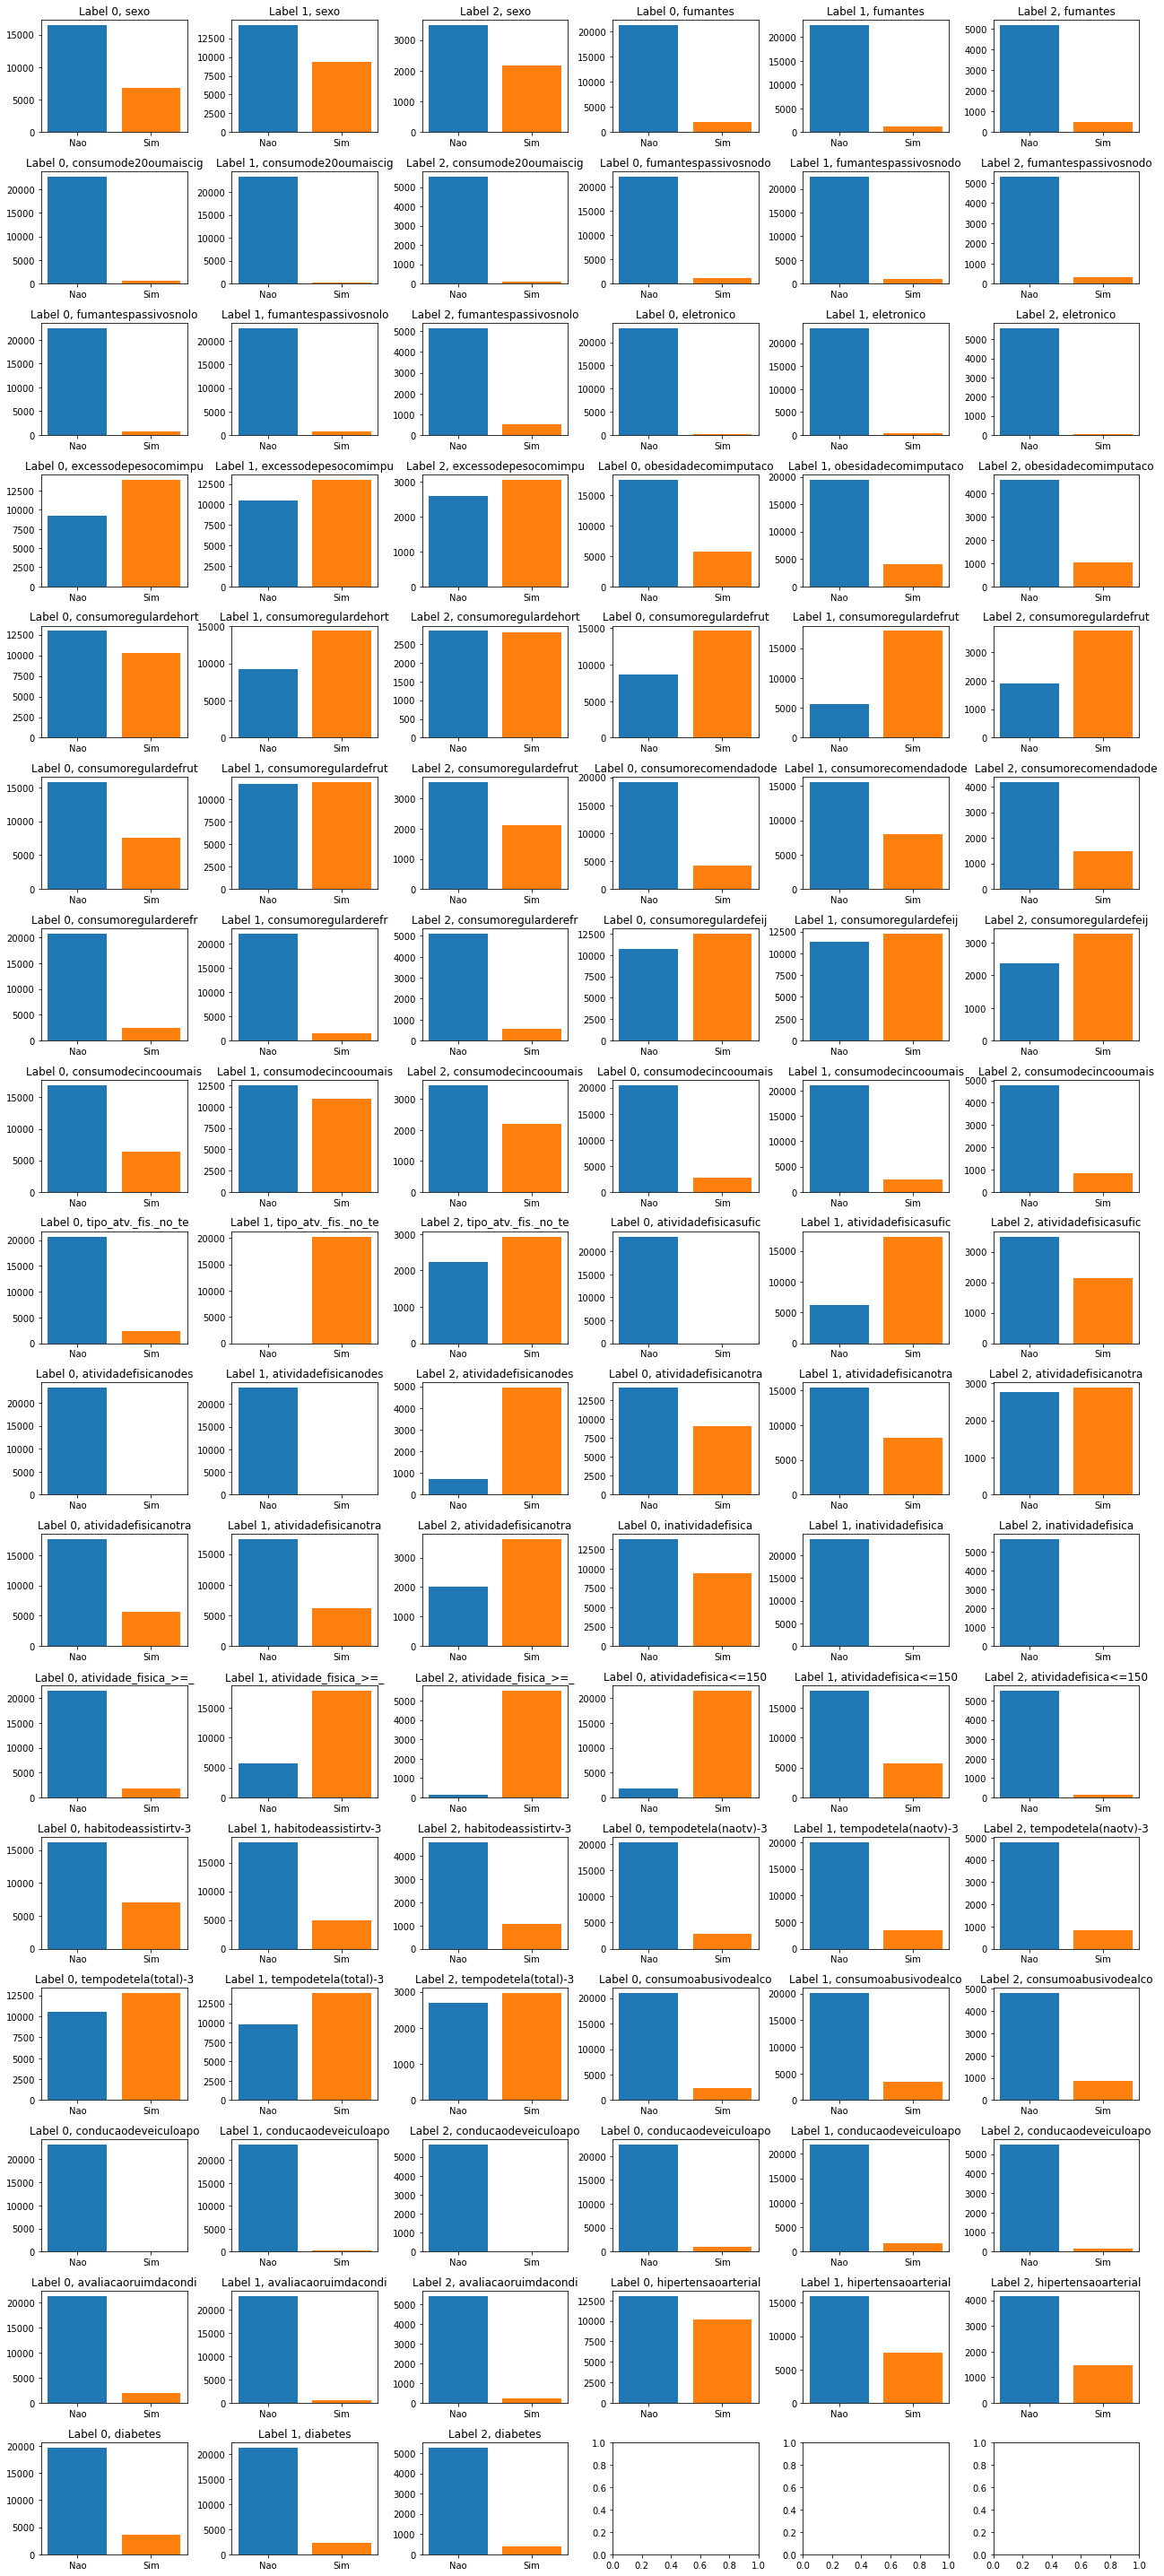

In [69]:
fig, axs = plt.subplots(17, 6, figsize=(18, 40))
labels_list = [0, 1, 2]
categoricos3 = [val for val in categoricos for _ in range(3)]
labels3 = []
for i in range(len(categoricos)):
    for j in [0, 1, 2]:
        labels3.append(j)


for ax, feat, i in zip(axs.flatten(), categoricos3, labels3):
        ax.bar('Nao',df_raw[feat].loc[(df_raw[feat]==0) & (df_raw['kmeans_labels']==i)].count())
        ax.bar('Sim',df_raw[feat].loc[(df_raw[feat]==1) & (df_raw['kmeans_labels']==i)].count())
        ax.set_title(f'Label {i}, {feat[:20]}')      
plt.tight_layout()

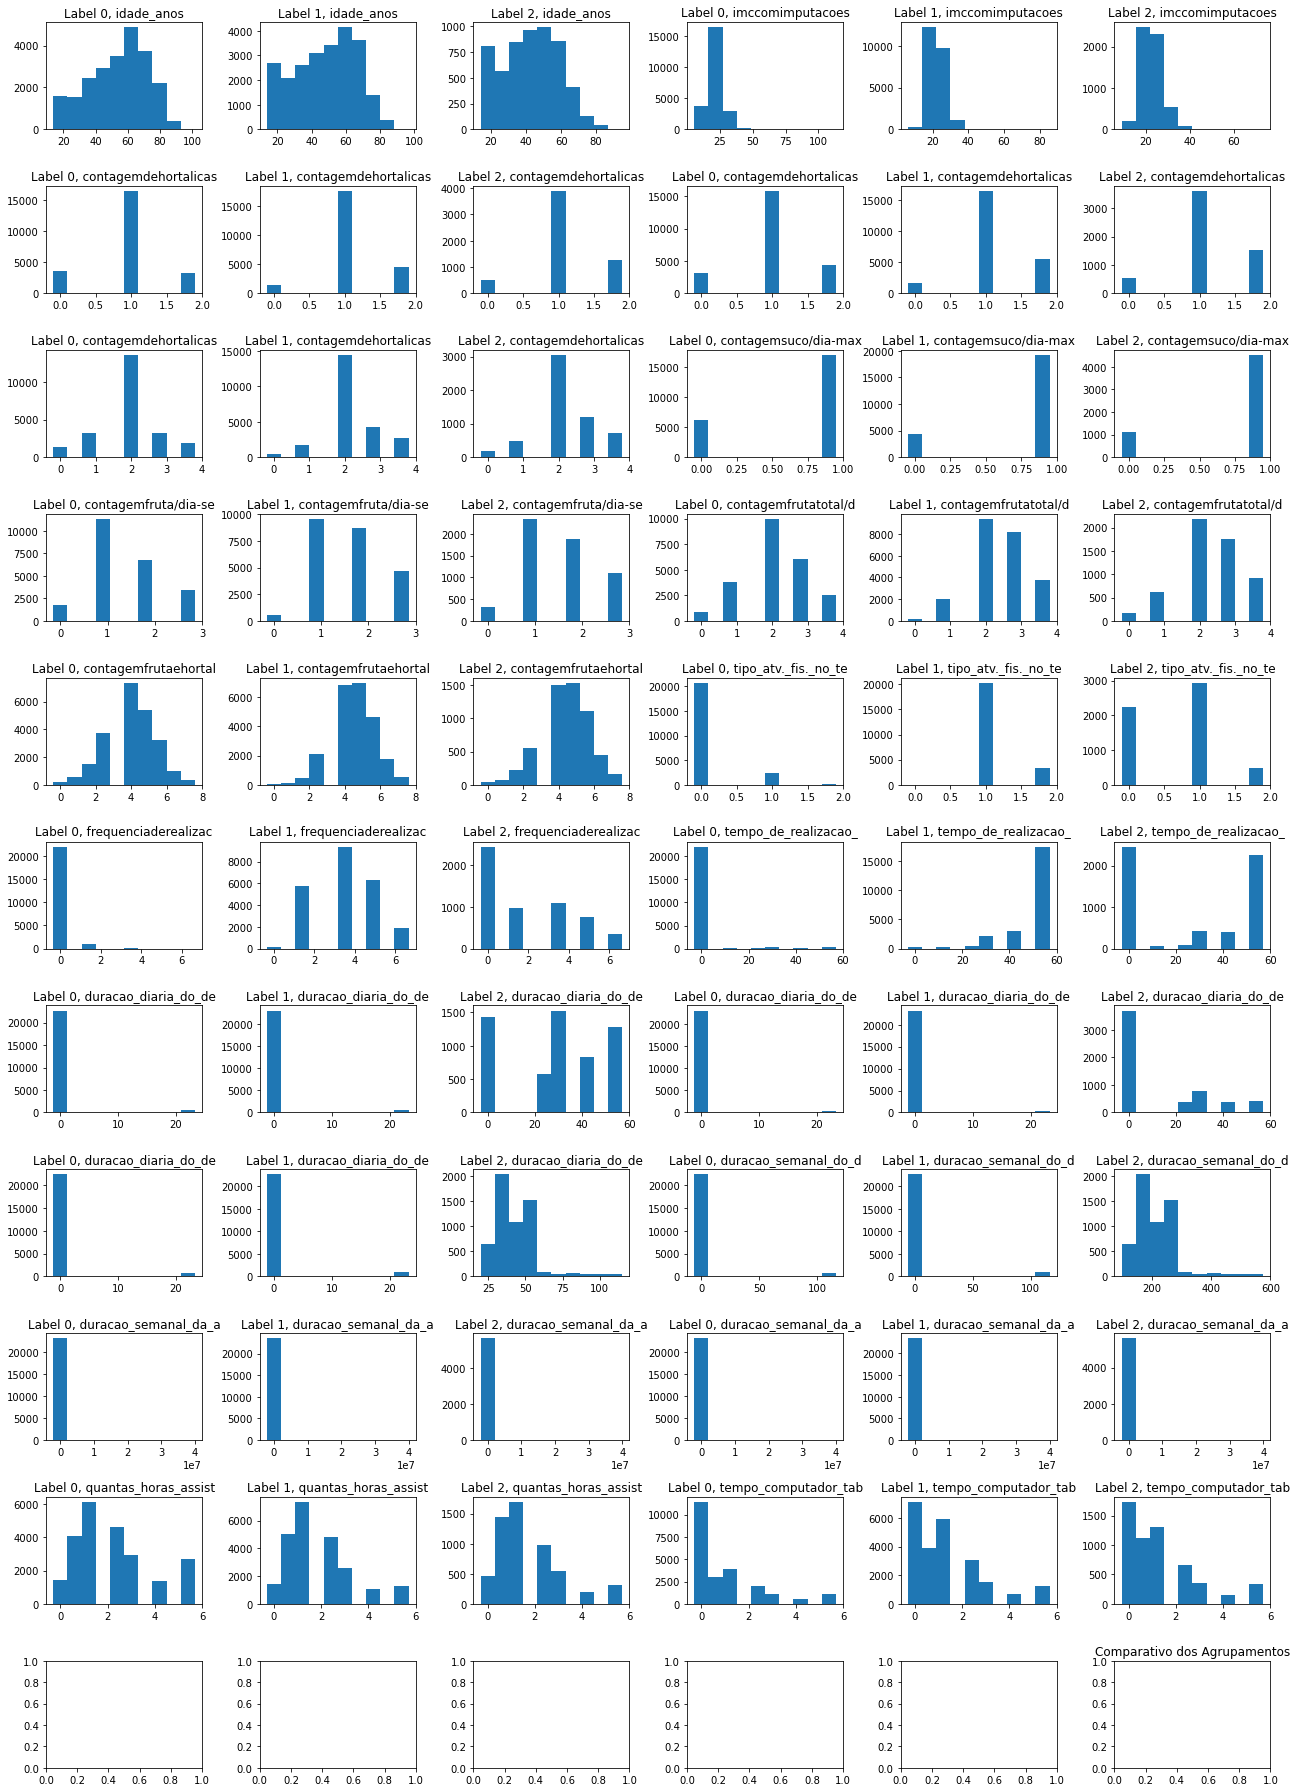

In [49]:
fig, axs = plt.subplots(11, 6, figsize=(18, 25))
labels_list = [0, 1, 2]
numericos3 = [val for val in numericos for _ in range(3)]
labels3 = []
for i in range(len(numericos)):
    for j in [0, 1, 2]:
        labels3.append(j)


for ax, feat, i in zip(axs.flatten(), numericos3, labels3):
        ax.hist(df_raw[feat].loc[df_raw['kmeans_labels']==i], align='left')
        ax.set_title(f'Label {i}, {feat[:20]}')
plt.title('Comparativo dos Agrupamentos')
plt.tight_layout()

In [50]:
df['labels'] = kmeans_labels

In [51]:
df

,idade_anos,sexo,fumantes,consumode20oumaiscigarrosaodia,fumantespassivosnodomicilio,fumantespassivosnolocaldetrabalho,eletronico,imccomimputacoes,excessodepesocomimputacoes,obesidadecomimputacoes,consumoregulardehortalicas(5xoumais/sem),consumoregulardefrutas(5xoumais/sem),consumoregulardefrutasehortalicas(5xoumais/sem),contagemdehortalicascruas/dia,contagemdehortalicascozidas/dia,contagemdehortalicas/dia,contagemsuco/dia-max.1/dia,contagemfruta/dia-semsuco,contagemfrutatotal/dia,contagemfrutaehortalicatotal/dia,consumorecomendadodefrutasehortalicas,consumoregularderefrigerantes(5xoumais/sem),consumoregulardefeijao(5xoumais/sem),consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas,consumodecincooumaisgruposdealimentosultraprocessados,tipo_atv._fis._no_tempo_livre_(lazer),frequenciaderealizacaodeatv.fis.notempolivre(lazer),tempo_de_realizacao_de_atv._fis._no_tempo_livre_(lazer),atividadefisicasuficientenolazer-somentetempo/semfrequencia(apartirde2012),atividadefisicanodeslocamento,atividadefisicanotrabalhodomestico,atividadefisicanotrabalho,inatividadefisica,duracao_diaria_do_deslocamento_para_trabalho_(min),duracao_diaria_do_deslocamento_para_o_escola_(min),duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_(min),duracao_semanal_da_atividade_fisica_laboral_(min),duracao_semanal_da_atividade_fisica_domestica(min),atividade_fisica_>=_150min/sem_em_3_dominios,atividadefisica<=150min/semem3dominios,habitodeassistirtv-3hrs/dia,tempodetela(naotv)-3hrs/dia,quantas_horas_assiste_tv_/_dia,tempo_computador_tablet_celular_tempolivre,tempodetela(total)-3hrs/dia,consumoabusivodealcool,conducaodeveiculoaposconsumoabusivodebebidaalcoolica,conducaodeveiculoaposconsumobebidaalcoolica,avaliacaoruimdacondicaodesaude,hipertensaoarterial,diabetes,labels
0,1.842368,1,0,0,0,1,0,-0.052905,1,0,0,1,0,-0.127991,-0.218804,-0.210393,0.537058,1.651825,1.668494,1.000081,0,0,1,0,0,-1.033187,-0.876111,-1.010082,0,0,0,1,0,-0.315934,-0.211785,-0.367364,-0.367364,-0.022432,-0.058448,1,0,0,0,-1.475289,-0.876998,0,0,0,0,0,1,0,0
1,0.583721,1,1,0,0,0,0,-0.763363,0,0,0,1,0,-0.127991,-2.032709,-1.331586,0.537058,-1.969388,-1.475022,-1.847797,0,1,1,0,0,-1.033187,-0.876111,-1.010082,0,1,0,1,0,3.254269,-0.211785,2.518052,2.518052,-0.025998,-0.058448,1,0,0,0,-1.475289,-0.876998,0,0,0,0,0,0,0,2
2,0.747893,1,0,0,0,0,0,-1.124675,0,0,0,0,0,-0.127991,-0.218804,-0.210393,0.537058,-0.762317,-0.427184,-0.423858,0,0,1,0,0,-1.033187,-0.876111,-1.010082,0,0,0,1,0,-0.315934,-0.211785,-0.367364,-0.367364,-0.024088,-0.058448,1,0,0,0,0.168452,-0.876998,0,0,0,1,0,1,1,0
3,1.349854,1,0,0,1,0,0,-0.974878,0,0,1,1,1,1.781612,1.595100,2.031992,-1.861998,0.444754,-0.427184,1.000081,1,0,1,1,0,0.592966,0.672341,0.230073,0,0,0,0,0,-0.315934,-0.211785,-0.367364,-0.367364,-0.025998,-0.058448,0,1,0,0,0.168452,-0.876998,0,0,0,0,0,0,0,1
4,0.857340,1,0,0,1,0,0,-0.259956,1,0,0,0,0,-0.127991,-0.218804,-0.210393,0.537058,0.444754,0.620655,0.288111,0,0,1,1,0,0.592966,0.672341,0.230073,0,1,1,1,0,3.254269,-0.211785,2.518052,2.518052,-0.025998,-0.058421,1,0,0,0,-0.489045,-0.876998,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52438,0.857340,0,0,0,0,0,0,-0.475517,0,0,1,1,1,1.781612,1.595100,2.031992,-1.861998,0.444754,-0.427184,1.000081,1,0,0,1,0,0.592966,-0.212489,0.949002,0,0,0,0,0,-0.315934,-0.211785,-0.367364,-0.367364,-0.025998,-0.058448,0,1,0,0,0.168452,-0.876998,0,0,0,0,0,0,0,1
52439,1.787644,0,0,0,0,0,0,-1.984818,0,0,1,1,1,-0.127991,-0.218804,-0.210393,-1.861998,-0.762317,-1.475022,-1.135828,0,0,1,0,0,2.219119,-0.212489,0.230073,0,0,1,1,0,-0.315934,-0.211785,-0.367364,-0.367364,0.024300,-0.057946,1,0,0,0,-0.817793,-0.876998,0,0,0,0,0,0,0,1
52440,1.732920,0,0,0,0,0,0,0.231484,1,0,0,0,0,-2.037594,-2.032709,-2.45277

In [64]:
print(f'Quantidade de Labels 0: {y[y==0].count()}')
print(f'Quantidade de Labels 1: {y[y==1].count()}')
print(f'Quantidade de Labels 2: {y[y==2].count()}')


Quantidade de Labels 0: 23244
Quantidade de Labels 1: 23554
Quantidade de Labels 2: 5645


In [52]:
X = df_raw.drop('kmeans_labels', axis=1)
y = df_raw['kmeans_labels']

In [53]:
#preparando para o XGBoost
for column_name in categoricos:
    X[column_name] = X[column_name].astype('int')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [55]:
scaler_train = StandardScaler()
X_train[numericos] = scaler_train.fit_transform(X_train[numericos])

In [56]:
scaler_test = StandardScaler()
X_test[numericos] = scaler_test.fit_transform(X_test[numericos])

In [58]:
rename = [
 'idade_anos',
 'sexo',
 'fumantes',
 'consumode20oumaiscigarrosaodia',
 'fumantespassivosnodomicilio',
 'fumantespassivosnolocaldetrabalho',
 'eletronico',
 'imccomimputacoes',
 'excessodepesocomimputacoes',
 'obesidadecomimputacoes',
 'consumoregulardehortalicas5xoumaissem',
 'consumoregulardefrutas5xoumaissem',
 'consumoregulardefrutasehortalicas5xoumaissem',
 'contagemdehortalicascruasdia',
 'contagemdehortalicascozidasdia',
 'contagemdehortalicasdia',
 'contagemsucodia-max1dia',
 'contagemfrutadia-semsuco',
 'contagemfrutatotaldia',
 'contagemfrutaehortalicatotaldia',
 'consumorecomendadodefrutasehortalicas',
 'consumoregularderefrigerantes5xoumaissem',
 'consumoregulardefeijao5xoumaissem',
 'consumodecincooumaisgruposdealimentosnaoouminimamenteprocessadosprotetoresparadoencascronicas',
 'consumodecincooumaisgruposdealimentosultraprocessados',
 'tipo_atv._fis._no_tempo_livre_lazer',
 'frequenciaderealizacaodeatv.fis.notempolivrelazer',
 'tempo_de_realizacao_de_atv._fis._no_tempo_livre_lazer',
 'atividadefisicasuficientenolazer-somentetempo/semfrequenciaapartirde2012',
 'atividadefisicanodeslocamento',
 'atividadefisicanotrabalhodomestico',
 'atividadefisicanotrabalho',
 'inatividadefisica',
 'duracao_diaria_do_deslocamento_para_trabalho_min',
 'duracao_diaria_do_deslocamento_para_o_escola_min',
 'duracao_diaria_do_deslocamento_para_o_trabalho_e_escola_min',
 'duracao_semanal_do_deslocamento_para_o_trabalho_e_escola_min',
 'duracao_semanal_da_atividade_fisica_laboral_min',
 'duracao_semanal_da_atividade_fisica_domesticamin',
 'atividade_fisica_maiorigual_150minsem_em_3_dominios',
 'atividadefisica_menorigual_150minsemem3dominios',
 'habitodeassistirtv-3hrsdia',
 'tempodetelanaotv-3hrsdia',
 'quantas_horas_assiste_tv_dia',
 'tempo_computador_tablet_celular_tempolivre',
 'tempodetelatotal-3hrsdia',
 'consumoabusivodealcool',
 'conducaodeveiculoaposconsumoabusivodebebidaalcoolica',
 'conducaodeveiculoaposconsumobebidaalcoolica',
 'avaliacaoruimdacondicaodesaude',
 'hipertensaoarterial',
 'diabetes']

In [59]:
# retirando caracteres não aceitos pelo algoritmo
new_headers = dict(zip(list(X.columns), rename))
X_train.rename(columns=new_headers, inplace=True)
X_test.rename(columns=new_headers, inplace=True)

In [60]:
model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
y_pred = model.predict(X_test)

In [70]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,5758,94,9
1,15,5818,7
2,10,15,1385


In [72]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1score = f1_score(y_test, y_pred, average='micro')
print("F1 Score: %.3f%%" % (f1score))

Accuracy: 98.86%
F1 Score: 0.989%


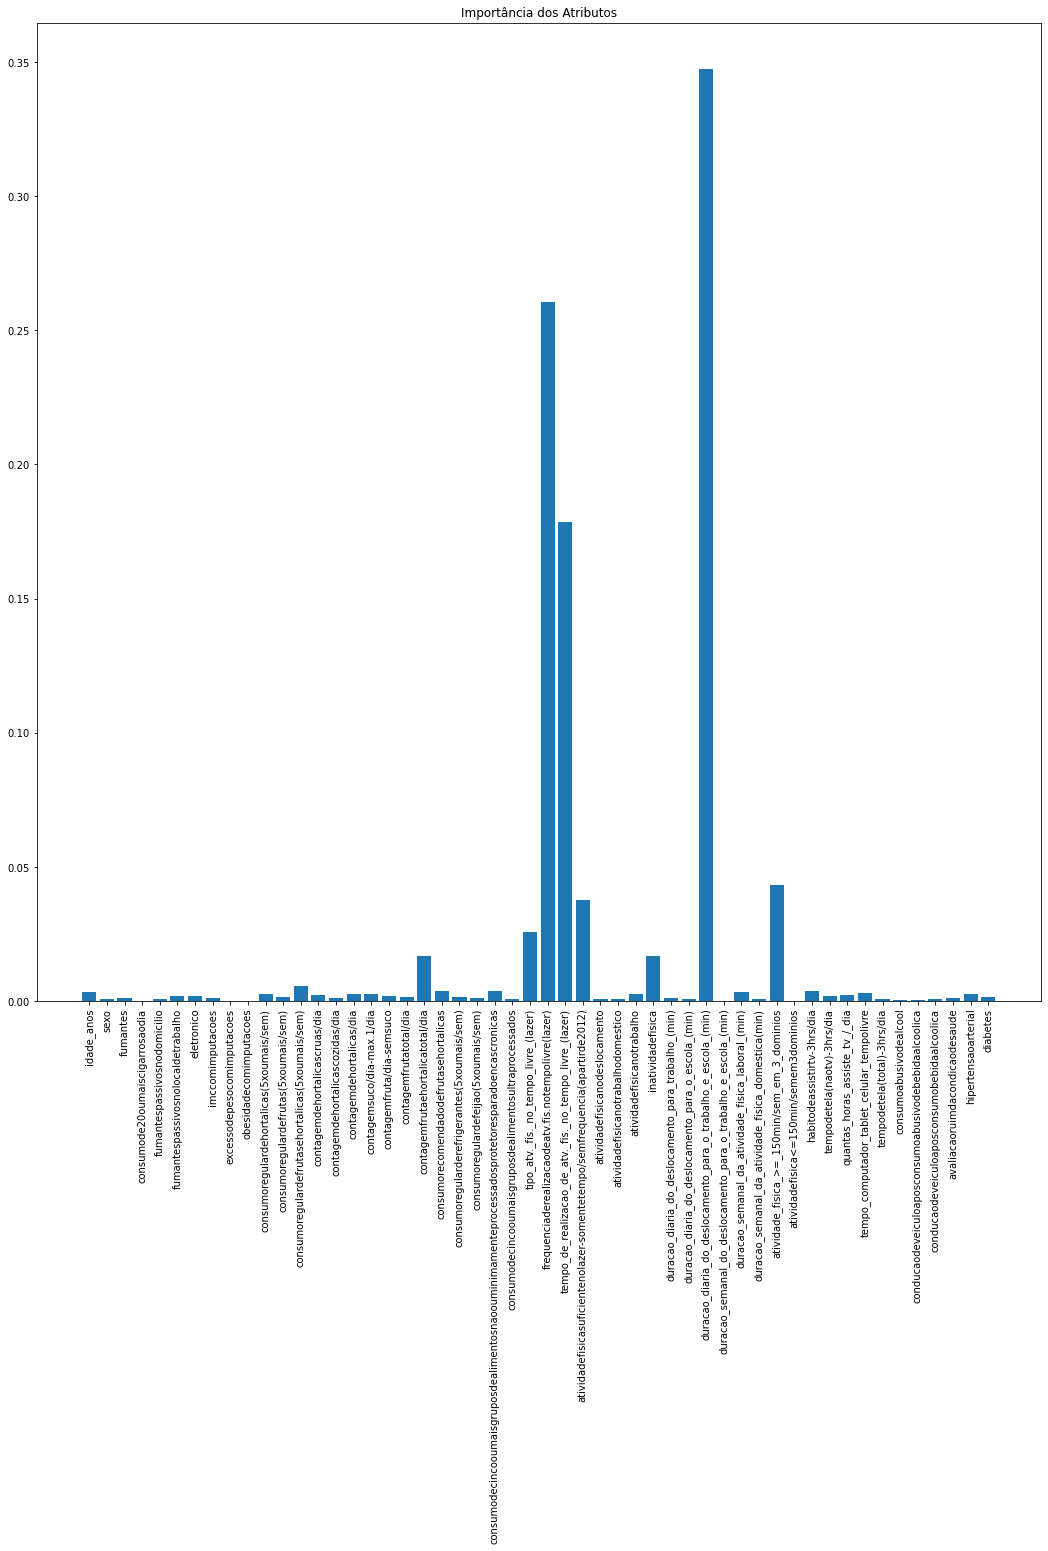

In [66]:
fig, axs = plt.subplots(1, 1, figsize=(18, 18))
axs.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.title('Importância dos Atributos')
plt.show()
